In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import itertools
from tqdm import tqdm_notebook
import gc
from time import sleep

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


### Read the data


In [16]:
##https://github.com/nitsaick/kaggle-predict-future-sales/blob/master/data_processing.ipynb

path="/kaggle/input/competitive-data-science-predict-future-sales"
# sales_train_df=pd.read_csv(path+"/sales_train.csv")
items=pd.read_csv(path+"/items.csv")
item_categories=pd.read_csv(path+"/item_categories.csv")
shops=pd.read_csv(path+"/shops.csv")
train = pd.read_csv(path + '/sales_train.csv')
test = pd.read_csv(path + '/test.csv')

groupby_cols = ['date_block_num', 'shop_id', 'item_id']

### EDA

 
Count total NaN in a DataFrame : 

        date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='item_price'>

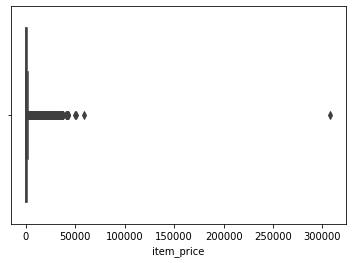

In [17]:
print(" \nCount total NaN in a DataFrame : \n\n",train.describe())
sns.boxplot(train['item_price'])

#### Data impution 
1. Imputuing 


In [18]:
category = items[['item_id', 'item_category_id']].drop_duplicates()
category.set_index(['item_id'], inplace=True)
category = category.item_category_id
train['category'] = train.item_id.map(category)

"""
Checking the distribution of data 

"""
# sns.displot(sales_train_df['item_price'], x="flipper_length_mm")

'\nChecking the distribution of data \n\n'

****
Add new features
****

In [19]:
"""
- Creting the item category by dropping the duplicate column .

"""
category = items[['item_id', 'item_category_id']].drop_duplicates()
category.set_index(['item_id'], inplace=True)
category = category.item_category_id
train['category'] = train.item_id.map(category)

In [20]:
item_categories['meta_category'] = item_categories.item_category_name.apply(lambda x: x.split(' ')[0])
item_categories['meta_category'] = pd.Categorical(item_categories.meta_category).codes
item_categories.set_index(['item_category_id'], inplace=True)
meta_category = item_categories.meta_category
train['meta_category'] = train.category.map(meta_category)

In [21]:
""" Extracting the city details from City 
extract the first letter from city and create the array of city using codes
adding the details to train column 
"""
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

In [22]:
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append(pd.Series([2015], index=[34]))

In [23]:
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append(pd.Series([11], index=[34]))

In [24]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[train['date_block_num'] == block_num]['shop_id'].unique()
    unique_items = train[train['date_block_num'] == block_num]['item_id'].unique()
    all_shops_items.append(np.array(list(itertools.product([block_num], unique_shops, unique_items)), dtype='int32'))

df = pd.DataFrame(np.vstack(all_shops_items), columns=groupby_cols, dtype='int32')
df = df.append(test, sort=True)

In [25]:
df['ID'] = df.ID.fillna(-1).astype('int32')
df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['category'] = df.item_id.map(category)
df['meta_category'] = df.category.map(meta_category)
df['city'] = df.shop_id.map(city)
train['category'] = train.item_id.map(category)

**Aggregations data**

In [26]:
%%time

gb = train.groupby(by=groupby_cols, as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby(by=['date_block_num', 'category'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_category'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'category'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price': ['mean', 'max']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean': 'target_price_mean', 'item_price_max': 'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

CPU times: user 19.3 s, sys: 6.19 s, total: 25.5 s
Wall time: 25.5 s


In [27]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype('int32')

**Mean encoded features**

In [28]:
%%time
for enc_cols in [['shop_id', 'category'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan

    for d in tqdm_notebook(df.date_block_num.unique()):
        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        print("gb mean value {}".format(gb))
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left')[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']

        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left')[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/34 [00:00<?, ?it/s]

gb mean value Empty DataFrame
Columns: [shop_id, category, target]
Index: []
gb mean value       shop_id  category     target
0           0         0   0.000000
1           0         1   0.000000
2           0         2   1.432432
3           0         3  10.000000
4           0         4   1.454545
...       ...       ...        ...
3634       59        78   0.000000
3635       59        79   0.000000
3636       59        81   0.000000
3637       59        82   0.000000
3638       59        83   1.600000

[3639 rows x 3 columns]
gb mean value       shop_id  category     target
0           0         0   0.500000
1           0         1   0.500000
2           0         2   1.329114
3           0         3  13.333333
4           0         4   1.809524
...       ...       ...        ...
3691       59        78   0.000000
3692       59        79   1.000000
3693       59        81   0.000000
3694       59        82   0.000000
3695       59        83   0.944444

[3696 rows x 3 columns]
gb me

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/34 [00:00<?, ?it/s]

gb mean value Empty DataFrame
Columns: [shop_id, item_id, target]
Index: []
gb mean value         shop_id  item_id  target
0             0       19     0.0
1             0       27     0.0
2             0       28     0.0
3             0       29     0.0
4             0       32     6.0
...         ...      ...     ...
548383       59    22163     0.0
548384       59    22164     0.0
548385       59    22166     0.0
548386       59    22167     0.0
548387       59    22168     0.0

[548388 rows x 3 columns]
gb mean value         shop_id  item_id  target
0             0       12     0.0
1             0       19     0.0
2             0       27     0.0
3             0       28     0.0
4             0       29     0.0
...         ...      ...     ...
609059       59    22163     0.0
609060       59    22164     0.0
609061       59    22166     0.0
609062       59    22167     0.0
609063       59    22168     0.0

[609064 rows x 3 columns]
gb mean value         shop_id  item_id  target
0  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/34 [00:00<?, ?it/s]

gb mean value Empty DataFrame
Columns: [shop_id, target]
Index: []
gb mean value     shop_id    target
0         0  0.666790
1         1  0.361306
2         2  0.086720
3         3  0.058040
4         4  0.158078
5         5  0.000000
6         6  0.269467
7         7  0.187817
8         8  0.180283
9        10  0.070753
10       12  0.059629
11       13  0.142206
12       14  0.133863
13       15  0.197654
14       16  0.224593
15       18  0.212107
16       19  0.226031
17       21  0.112675
18       22  0.139160
19       23  0.238078
20       24  0.131820
21       25  0.582066
22       26  0.175482
23       27  0.653851
24       28  0.488838
25       29  0.341466
26       30  0.365250
27       31  0.708059
28       32  0.152680
29       34  0.000000
30       35  0.160045
31       36  0.000000
32       37  0.180704
33       38  0.129020
34       39  0.000000
35       41  0.151192
36       42  0.292925
37       43  0.208133
38       44  0.128415
39       45  0.121983
40       46  0.24

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/34 [00:00<?, ?it/s]

gb mean value Empty DataFrame
Columns: [item_id, target]
Index: []
gb mean value        item_id    target
0           19  0.022222
1           27  0.155556
2           28  0.177778
3           29  0.088889
4           30  0.000000
...        ...       ...
12271    22163  0.000000
12272    22164  0.000000
12273    22166  0.000000
12274    22167  0.000000
12275    22168  0.044444

[12276 rows x 2 columns]
gb mean value        item_id    target
0           12  0.021739
1           19  0.022222
2           27  0.109890
3           28  0.175824
4           29  0.088889
...        ...       ...
13442    22163  0.000000
13443    22164  0.000000
13444    22166  0.000000
13445    22167  0.000000
13446    22168  0.043956

[13447 rows x 2 columns]
gb mean value        item_id    target
0           12  0.021739
1           19  0.022222
2           27  0.102190
3           28  0.167883
4           29  0.088889
...        ...       ...
14182    22163  0.000000
14183    22164  0.000000
14184    22166

**Downcast**

In [29]:
def downcast_dtypes(df):
    float32_cols = [c for c in df if df[c].dtype == 'float64']
    int32_cols = [c for c in df if df[c].dtype in ['int64', 'int16', 'int8']]

    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols] = df[int32_cols].astype(np.int32)

    return df

In [30]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

**Lag features**

In [31]:
%%time

shift_range = [1, 2, 3, 4, 5, 12]

shifted_columns = [c for c in df if 'target' in c]

for shift in tqdm_notebook(shift_range):
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    type(df)
    df = downcast_dtypes(df)
    del shifted_data
    gc.collect()
    sleep(1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 2min 1s, sys: 43.2 s, total: 2min 44s
Wall time: 2min 50s


**Features Interaction**

In [32]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1'] * 2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2']) * 2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [33]:
df = downcast_dtypes(df)
df.to_pickle('df.pkl')